In [35]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification
import csv
import warnings 
warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [10]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0 or row[2].find('normal') >= 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots)            

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'GH'
    else:
        label = 'BH'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7404:4:404:,rnd_1bh-2_2019-02-14_15:38_,199,118.358291,2223.949716,47.158771,2,67.2,446.0,0.005,10,BH
1,aaaa::212:7405:5:505:,rnd_1bh-2_2019-02-14_15:38_,162,147.724074,7966.380721,89.254584,2,72.5,673.0,0.190,7,BH
2,aaaa::212:7409:9:909:,rnd_1bh-2_2019-02-14_15:38_,200,58.024500,1382.140352,37.177148,1,28.3,448.0,0.000,5,BH
3,aaaa::212:740a:a:a0a:,rnd_1bh-2_2019-02-14_15:38_,172,121.721512,3900.118891,62.450932,2,68.1,549.0,0.140,7,BH
4,aaaa::212:7402:2:202:,rnd_1bh-2_2019-02-14_15:38_,172,133.307558,4593.581989,67.775969,2,71.9,489.0,0.140,6,BH


Stats for single network

In [11]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 9)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 9, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 9, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 9, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9
0,grid9_1bh-3_2019-02-13_16:28_,BH,0.070,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
1,grid9_1bh-3_2019-02-13_22:05_,BH,0.045,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18,9.223372e+18
2,grid9_1bh-5_2019-02-13_15:31_,BH,0.075,1.900000e-01,2.000000e-02,2.450000e-01,8.500000e-02,9.500000e-02,1.900000e-01,1.450000e-01,4.000000e-02
3,grid9_1bh-5_2019-02-13_21:44_,BH,0.020,1.600000e-01,1.150000e-01,1.750000e-01,2.100000e-01,1.350000e-01,3.000000e-02,7.500000e-02,9.000000e-02
4,grid9_1bh-6_2019-02-13_12:59_,BH,0.080,1.550000e-01,4.000000e-02,2.050000e-01,1.000000e-01,1.650000e-01,1.000000e-02,1.650000e-01,9.223372e+18


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

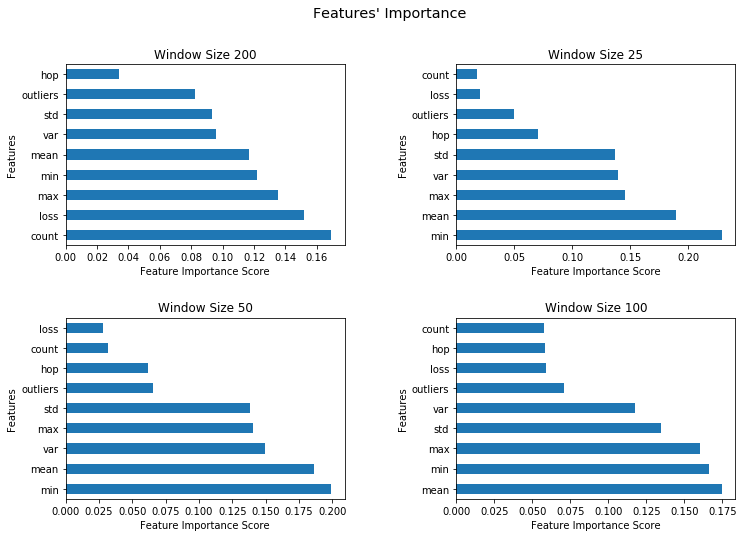

In [12]:
plots_analysis.random_forests_features_selection(trace_stats)

In [13]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [14]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [15]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [36]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [17]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

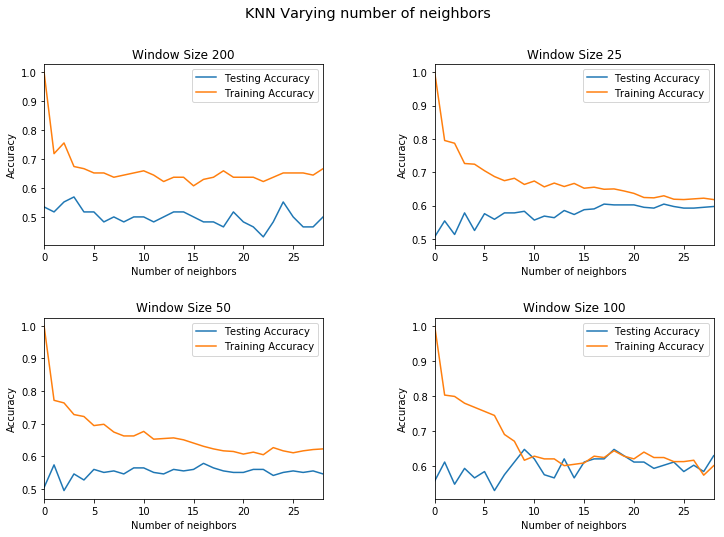

In [18]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [19]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=20)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [20]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=30)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [21]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [22]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [23]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [24]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [37]:
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [26]:
'''
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])
'''

'\ncv_net_results = pd.concat([cv_net_results, \n                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)\n                    ])\n'

# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [38]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=10)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [39]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [40]:
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [41]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Per Node Results
Results from each model

In [31]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.500000,0.467442,0.474760,0.453008,0.112267,0.007605
1,Random Forest,25,0.587530,0.562298,0.555021,0.552285,0.225532,0.017000
2,Random Forest,50,0.564815,0.554167,0.555814,0.553758,0.127858,0.008543
3,Random Forest,100,0.585586,0.548889,0.545549,0.545406,0.080501,0.008683
4,KNN,200,0.517241,0.457500,0.479567,0.417504,0.001575,0.005632
5,KNN,25,0.601918,0.576049,0.541364,0.509509,0.002579,0.016223
6,KNN,50,0.555556,0.468071,0.483184,0.440354,0.001431,0.010911
7,KNN,100,0.639640,0.604167,0.575052,0.568765,0.001252,0.004969
8,SVM,200,0.568966,0.583019,0.526442,0.449715,0.004954,0.001226
9,SVM,25,0.573141,0.502530,0.500927,0.437102,0.026880,0.007909


Here we plot the average results for each model computed with cross validation

In [32]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.534656
1,Random Forest,25,0.594464
2,Random Forest,50,0.593242
3,Random Forest,100,0.613893
4,KNN,200,0.546100
5,KNN,25,0.575680
6,KNN,50,0.551545
7,KNN,100,0.603010
8,SVM,200,0.560445
9,SVM,25,0.564138


# Network Results
Here we print the results from each model on the whole network

In [33]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.750000,0.733333,0.733333,0.733333,0.061856,0.007730
1,Random Forest,25,0.566667,0.283333,0.500000,0.361702,0.066607,0.006973
2,Random Forest,50,0.566667,0.420000,0.450000,0.422222,0.063684,0.010297
3,Random Forest,100,0.466667,0.269231,0.388889,0.318182,0.070787,0.006381
4,KNN,200,0.875000,0.916667,0.833333,0.854545,0.000925,0.001463
5,KNN,25,0.550000,0.512987,0.507919,0.472485,0.001393,0.005263
6,KNN,50,0.633333,0.327586,0.475000,0.387755,0.001180,0.003303
7,KNN,100,0.400000,0.392857,0.388889,0.389140,0.000873,0.001909
8,SVM,200,0.750000,0.800000,0.800000,0.750000,0.001103,0.000625
9,SVM,25,0.566667,0.283333,0.500000,0.361702,0.001882,0.001084


Here we plot the average results for each model computed with cross validation

In [34]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.759259
1,Random Forest,25,0.585256
2,Random Forest,50,0.629234
3,Random Forest,100,0.678922
4,KNN,200,0.722222
5,KNN,25,0.585105
6,KNN,50,0.619133
7,KNN,100,0.638480
8,OneVsRestClassifier (SVM),200,0.481481
9,OneVsRestClassifier (SVM),25,0.639982
